In [1]:
import pandas as pd

# Project Imports
from notebooks.consts import *
from notebooks.preprocessing import preprocess_aso_data, get_unique_genes
from tauso.new_model.data_handling import get_populated_df_with_structure_features

# New Refactored Modules
from tauso.algorithms.genomic_context_windows import add_external_mrna_and_context_columns
from tauso.data.data import get_data_dir

# Pandas Display Settings
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', None)

In [2]:
all_data = preprocess_aso_data(UPDATED_CSV, include_smiles=False)

print(f"Data ready. Shape: {all_data.shape}")

Preprocessing complete. Final valid rows: 29987
Data ready. Shape: (29987, 29)


In [3]:
from tauso.genome.TranscriptMapper import GeneCoordinateMapper, build_gene_sequence_registry
from tauso.genome.read_human_genome import get_locus_to_data_dict
from tauso.data.data import get_paths

target_genes = get_unique_genes(all_data)

paths = get_paths('GRCh38')
mapper = GeneCoordinateMapper(paths['db'])

# C. Fetch the raw genomic data
# This is the "heavy" part, but limited only to your experimental genes
gene_to_data = get_locus_to_data_dict(include_introns=False, gene_subset=target_genes)

# D. Build the Registry object
# This provides the {gene: {'cds_sequence': '...'}} mapping
ref_registry = build_gene_sequence_registry(
    genes=target_genes,
    gene_to_data=gene_to_data,
    mapper=mapper
)

print(f"Registry rebuilt for {len(ref_registry)} experimental genes.")

Elapsed DB:  0.0003027915954589844
Elapsed Fasta:  0.0003027915954589844
Length:  3267117988
Registry rebuilt for 15 experimental genes.


In [4]:
# Add structural features (e.g. secondary structure energy)
all_data = get_populated_df_with_structure_features(all_data, target_genes, gene_to_data)

In [5]:
FLANK_SIZES_PREMRNA = [20, 30, 40, 50, 60, 70]
CDS_WINDOWS = [20, 30, 40, 50, 60, 70]

# Run the optimized context generator
# This creates columns like 'flank_sequence_50' containing the actual RNA sequence
df_with_context = add_external_mrna_and_context_columns(
    df=all_data,
    mapper=mapper,
    gene_registry=ref_registry,
    flank_sizes_premrna=FLANK_SIZES_PREMRNA,
    flank_sizes_cds=CDS_WINDOWS
)

print("Genomic context added. Available columns:", [c for c in df_with_context.columns if 'flank' in c])

Genomic context added. Available columns: ['flank_sequence_20', 'flank_sequence_30', 'flank_sequence_40', 'flank_sequence_50', 'flank_sequence_60', 'flank_sequence_70']


In [7]:
import numpy as np

def load_attract_data(csv_path, pwm_path):
    """
    Parses the processed ATtRACT files.
    """
    print(f"Loading RBP metadata from {csv_path}...")
    # NOTE: We now read the CSV created by setup_attract (comma-separated)
    df = pd.read_csv(csv_path)

    # Map Gene Name -> List of Matrix IDs
    # (No need to filter for Organism here, it was done in setup_attract)
    rbp_to_matrices = df.groupby('Gene_name')['Matrix_id'].apply(list).to_dict()

    print(f"Loading PWM matrices from {pwm_path}...")
    pwms = {}
    current_matrix_id = None
    matrix_data = []

    with open(pwm_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line: continue

            if line.startswith('>'):
                if current_matrix_id and matrix_data:
                    pwms[current_matrix_id] = np.array(matrix_data)

                # Header format: >MatrixID Length
                parts = line.split()
                current_matrix_id = parts[0][1:] # Remove '>'
                matrix_data = []
            else:
                # Cols: A C G U
                probs = [float(x) for x in line.split()]
                matrix_data.append(probs)

        # Save the last matrix
        if current_matrix_id and matrix_data:
            pwms[current_matrix_id] = np.array(matrix_data)

    print(f"Loaded {len(pwms)} PWMs covering {len(rbp_to_matrices)} unique RBPs.")
    return rbp_to_matrices, pwms

# Execute Loading
data_dir = get_data_dir()

# Point to the files created by the CLI
attract_csv_path = os.path.join(data_dir, "RBS_motifs_Homo_sapiens.csv")
attract_pwm_path = os.path.join(data_dir, "pwm.txt")

# Check if they exist before running
if not os.path.exists(attract_csv_path) or not os.path.exists(attract_pwm_path):
    raise FileNotFoundError("ATtRACT files not found. Please run 'python cli.py setup_attract' first.")

rbp_map, pwm_db = load_attract_data(attract_csv_path, attract_pwm_path)

Loading RBP metadata from /home/michael/.local/share/tauso/RBS_motifs_Homo_sapiens.csv...
Loading PWM matrices from /home/michael/.local/share/tauso/pwm.txt...
Loaded 1583 PWMs covering 160 unique RBPs.


In [8]:
def calculate_total_affinity(sequence, pwm_matrix, background=0.25):
    """
    Scans sequence with PWM. Returns aggregated score (Total Binding Affinity).
    """
    if pd.isna(sequence) or len(sequence) == 0:
        return 0.0

    # 1. Map sequence to indices (A=0, C=1, G=2, U/T=3)
    base_map = {'A': 0, 'C': 1, 'G': 2, 'U': 3, 'T': 3}
    seq_indices = [base_map.get(base, -1) for base in str(sequence).upper()]

    seq_len = len(seq_indices)
    motif_len = len(pwm_matrix)

    if seq_len < motif_len:
        return 0.0

    # 2. Convert PWM probabilities to Log-Odds Weights
    # weight = log2(prob / background)
    epsilon = 1e-6
    weights = np.log2((pwm_matrix + epsilon) / background)

    total_score = 0.0

    # 3. Sliding Window Scan
    # We sum scores > 0 (indicating affinity higher than background)
    for i in range(seq_len - motif_len + 1):
        window = seq_indices[i : i + motif_len]
        if -1 in window: continue # Skip Ns

        # Calculate score for this position
        score = 0
        for pos, base_idx in enumerate(window):
            score += weights[pos][base_idx]

        if score > 0:
            total_score += score

    return total_score

In [11]:
# Cell 8: Calculate RBP Features (Batch Processing) with Parallelization (Optimized)
from tqdm.notebook import tqdm
from pandarallel import pandarallel

# 1. Initialize Parallel Workers
pandarallel.initialize(progress_bar=False, nb_workers=32)

# Select RBPs
target_rbps = list(rbp_map.keys())
print(f"Preparing to calculate features for {len(target_rbps)} RBPs...")

window_col = "flank_sequence_50"

# Pre-calculate log-odds matrices
optimized_pwms = {}
for rbp in target_rbps:
    matrix_ids = rbp_map[rbp]
    valid_mids = [m for m in matrix_ids if m in pwm_db]
    if valid_mids:
        optimized_pwms[rbp] = pwm_db[valid_mids[0]]

print(f"optimized_pwms ready. Starting parallel extraction...")

# 2. FEATURE EXTRACTION
# We store new columns in a dictionary first to avoid "DataFrame Fragmentation"
new_features_dict = {}

for rbp, matrix in tqdm(optimized_pwms.items(), desc="Processing RBPs"):
    col_name = f"RBP_{rbp}_Affinity"

    # Parallel Calculation
    new_features_dict[col_name] = df_with_context[window_col].parallel_apply(
        lambda seq: calculate_total_affinity(seq, matrix)
    )

# 3. CONCATENATION (The Fast Part)
print("Merging new features into dataframe...")
new_features_df = pd.DataFrame(new_features_dict)

# Join efficiently
df_with_context = pd.concat([df_with_context, new_features_df], axis=1)

print(f"Done. Added {len(new_features_dict)} RBP features.")

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Preparing to calculate features for 160 RBPs...
optimized_pwms ready. Starting parallel extraction...


Processing RBPs:   0%|          | 0/160 [00:00<?, ?it/s]

Merging new features into dataframe...
Done. Added 160 RBP features.


In [15]:
# Cell 8: FIX & REGENERATE
from tqdm.notebook import tqdm
from pandarallel import pandarallel

# 1. CLEANUP: Remove Duplicate Columns
# This keeps the first occurrence and drops subsequent duplicates
print(f"Original Shape: {df_with_context.shape}")
df_with_context = df_with_context.loc[:, ~df_with_context.columns.duplicated()]
print(f"Shape after de-duplication: {df_with_context.shape}")

# 2. CLEANUP: Drop ALL old RBP Affinity columns to start fresh
# This ensures we don't have lingering bad data
old_rbp_cols = [c for c in df_with_context.columns if c.endswith("_Affinity")]
if old_rbp_cols:
    print(f"Dropping {len(old_rbp_cols)} old RBP columns to prevent conflicts...")
    df_with_context = df_with_context.drop(columns=old_rbp_cols)

# 3. Initialize Parallel Workers
pandarallel.initialize(progress_bar=False, nb_workers=32)

# Select RBPs
target_rbps = list(rbp_map.keys())
window_col = "flank_sequence_50"

# 4. SANITIZE INPUT
# Ensure no NaNs in sequence. Parallel Apply fails on NaNs.
df_with_context[window_col] = df_with_context[window_col].fillna("").astype(str)

# Pre-calculate log-odds matrices
optimized_pwms = {}
for rbp in target_rbps:
    matrix_ids = rbp_map[rbp]
    valid_mids = [m for m in matrix_ids if m in pwm_db]
    if valid_mids:
        optimized_pwms[rbp] = pwm_db[valid_mids[0]]

print(f"Starting parallel extraction for {len(optimized_pwms)} RBPs...")

# 5. FEATURE EXTRACTION (Dictionary Accumulation)
new_features_dict = {}

for rbp, matrix in tqdm(optimized_pwms.items(), desc="Processing RBPs"):
    col_name = f"RBP_{rbp}_Affinity"

    # Calculate
    new_features_dict[col_name] = df_with_context[window_col].parallel_apply(
        lambda seq: calculate_total_affinity(seq, matrix)
    )

# 6. CONCATENATION
print("Merging new features...")
new_features_df = pd.DataFrame(new_features_dict, index=df_with_context.index)
df_with_context = pd.concat([df_with_context, new_features_df], axis=1)

print(f"Done. DataFrame Shape: {df_with_context.shape}")

Original Shape: (29987, 373)
Shape after de-duplication: (29987, 213)
Dropping 160 old RBP columns to prevent conflicts...
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Starting parallel extraction for 160 RBPs...


Processing RBPs:   0%|          | 0/160 [00:00<?, ?it/s]

Merging new features...
Done. DataFrame Shape: (29987, 213)


Analyzing Correlations with Inhibition...
Top Positive Correlations (RBP helps Inhibition?):


,Feature,Pearson,Spearman,NMI_max
56,RBP_HNRNPL_Affinity,0.116,0.138,0.046
62,RBP_IGF2BP2_Affinity,0.080,0.124,0.056
63,RBP_IGF2BP3_Affinity,0.083,0.121,0.045
112,RBP_RBMS1_Affinity,0.120,0.119,0.063
150,RBP_YBX1_Affinity,0.061,0.096,0.048
147,RBP_TUT1_Affinity,0.061,0.087,0.043
5,RBP_AKAP1_Affinity,0.065,0.081,0.012
41,RBP_HNRNPA0_Affinity,0.047,0.080,0.007
44,RBP_HNRNPA2B1_Affinity,0.047,0.080,0.004
113,RBP_RBMS3_Affinity,0.057,0.077,0.063


Top Negative Correlations (RBP hinders Inhibition?):


,Feature,Pearson,Spearman,NMI_max
136,RBP_SRSF6_Affinity,-0.115,-0.129,0.024
20,RBP_DDX58_Affinity,-0.079,-0.101,0.005
40,RBP_GRSF1_Affinity,-0.079,-0.099,0.007
32,RBP_ESRP2_Affinity,-0.080,-0.097,0.055
22,RBP_DHX9_Affinity,-0.103,-0.093,0.013
111,RBP_RBM8A_Affinity,-0.115,-0.093,0.058
158,RBP_ZNF638_Affinity,-0.053,-0.087,0.045
21,RBP_DHX58_Affinity,-0.093,-0.085,0.010
135,RBP_SRSF5_Affinity,-0.068,-0.083,0.043
100,RBP_RBM14_Affinity,-0.093,-0.081,0.030


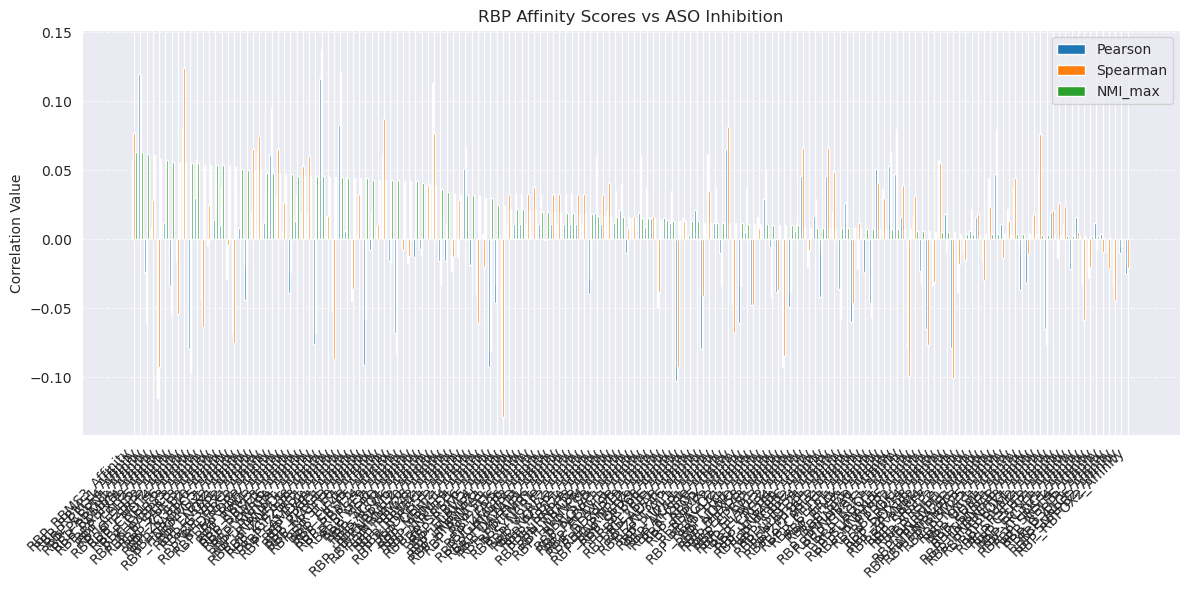

In [16]:
from notebooks.utils.correlation_test import analyze_feature_correlations, plot_feature_correlations_by_prefix

# 1. Identify new feature columns
rbp_feature_cols = [c for c in df_with_context.columns if c.startswith("RBP_")]

# 2. Run Correlation Analysis
print("Analyzing Correlations with Inhibition...")
results_df = analyze_feature_correlations(
    df_with_context,
    target='log_inhibition',
    features=rbp_feature_cols # Pass explicit list to speed up if dataframe is huge
)

# 3. Show Top Correlated RBPs
print("Top Positive Correlations (RBP helps Inhibition?):")
display(results_df.sort_values('Spearman', ascending=False).head(10))

print("Top Negative Correlations (RBP hinders Inhibition?):")
display(results_df.sort_values('Spearman', ascending=True).head(10))

# 4. Visual Plot
plot_feature_correlations_by_prefix(
    results_df,
    prefix='RBP_',
    title='RBP Affinity Scores vs ASO Inhibition'
)

Training Set: 23199 ASOs across 12 Genes
Test Set:     6788 ASOs across 3 Genes
Training Random Forest Regressor...

--- Model Results (RBP Features Only) ---
Pearson Correlation: 0.327
RMSE (Inhibition %): 1438.65
R² Score:            -0.406


/tmp/ipykernel_1568877/64657449.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


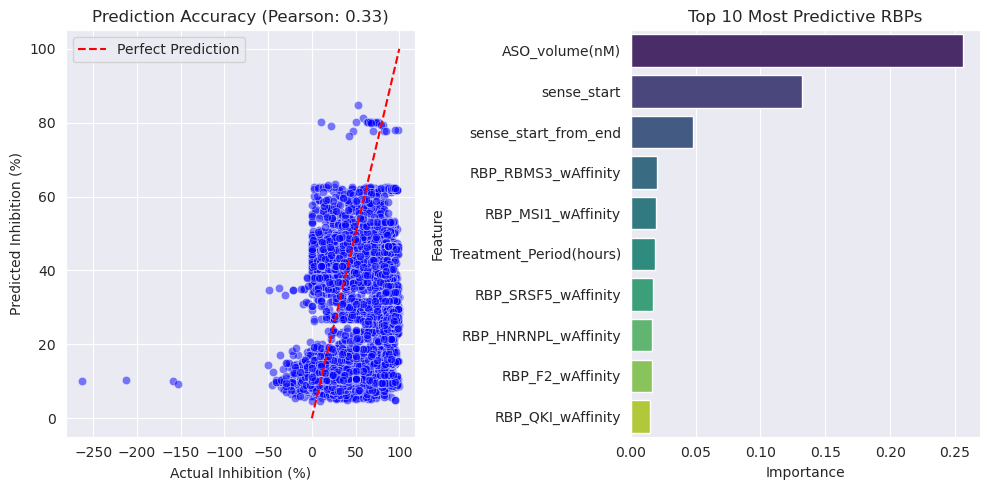

In [21]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Setup Data
# ---------------------------------------------------------
rbp_features = [c for c in df_with_context.columns if c.endswith("_wAffinity")]
general_features = ['sense_start', 'sense_start_from_end', 'sense_exon', 'sense_utr', 'sense_intron']

# B. Combine Features (Volume + Period + Genomic + RBPs)
# We safely check global variables or fall back to strings if not defined
vol_col = VOLUME
period_col = TREATMENT_PERIOD
target_col = INHIBITION

feature_cols = [vol_col, period_col] + general_features + rbp_features



# Drop rows with NaNs in features/target to prevent errors
# We assume 'gene_name' is the column with the gene identifier.
# Adjust 'gene_name' to 'Target' or 'GeneID' if your column is named differently.
model_df = df_with_context.dropna(subset=[target_col, CANONICAL_GENE] + feature_cols).copy()

X = model_df[feature_cols]
y = model_df[target_col]
groups = model_df[CANONICAL_GENE] # CRITICAL: We group by Gene

# 2. Strict Gene-Based Split
# ---------------------------------------------------------
# This ensures a gene is ENTIRELY in training or ENTIRELY in test.
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"Training Set: {len(X_train)} ASOs across {model_df.iloc[train_idx][CANONICAL_GENE].nunique()} Genes")
print(f"Test Set:     {len(X_test)} ASOs across {model_df.iloc[test_idx][CANONICAL_GENE].nunique()} Genes")

# 3. Train Model (Random Forest)
# ---------------------------------------------------------
print("Training Random Forest Regressor...")
rf = RandomForestRegressor(
    n_estimators=100,
    n_jobs=-1,        # Use all CPU cores
    random_state=42,
    max_depth=15      # Prevent overfitting to noise
)
rf.fit(X_train, y_train)

# 4. Evaluate Performance
# ---------------------------------------------------------
y_pred = rf.predict(X_test)

pearson_corr, _ = pearsonr(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n--- Model Results (RBP Features Only) ---")
print(f"Pearson Correlation: {pearson_corr:.3f}")
print(f"RMSE (Inhibition %): {rmse:.2f}")
print(f"R² Score:            {r2:.3f}")

# 5. Visualization
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))

# Plot A: Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='blue')
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Inhibition (%)")
plt.ylabel("Predicted Inhibition (%)")
plt.title(f"Prediction Accuracy (Pearson: {pearson_corr:.2f})")
plt.legend()

# Plot B: Feature Importance
plt.subplot(1, 2, 2)
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Most Predictive RBPs")
plt.tight_layout()
plt.show()

In [18]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from pandarallel import pandarallel

# ==============================================================================
# 0. SETUP PARALLELIZATION
# ==============================================================================
# Initialize shared memory for 32 cores.
# We disable the inner progress bar to avoid cluttering the output with 100s of bars.
pandarallel.initialize(progress_bar=False, nb_workers=32)

# ==============================================================================
# 1. CONFIGURATION & MAPPING
# ==============================================================================
CELL_LINE_TO_DEPMAP = {
    'HepG': 'ACH-000739',
    'SNU-449': 'ACH-000420',
    'HeLa': 'ACH-001086',
    'A431': 'ACH-001328',
    'SK-MEL-28': 'ACH-000615',
    'SH-SY5Y': 'ACH-001188',
    'U251': 'ACH-000232',
    'U-251 MG': 'ACH-000232',
    'H929': 'ACH-000050',
    'KMS11': 'ACH-000714',
    'NCI-H460': 'ACH-000463',
    'SK-N-AS': 'ACH-000260',
    'SK-N-SH': 'ACH-000149',
}

# ==============================================================================
# 2. LOAD EXPRESSION MAP (Directly from Disk)
# ==============================================================================
def load_expression_map_from_dict():
    data_dir = get_data_dir()
    expression_dir = os.path.join(data_dir, "processed_expression")

    print(f"Loading expression data from: {expression_dir}")

    expr_map = {}
    valid_series = []

    for cell_name, depmap_id in tqdm(CELL_LINE_TO_DEPMAP.items(), desc="Loading Expression"):
        filename = f"{depmap_id}_expression.csv"
        full_path = os.path.join(expression_dir, filename)

        if os.path.exists(full_path):
            try:
                # Read CSV
                df_expr = pd.read_csv(full_path)

                # Check for 'Gene' and 'expression_norm'
                if "Gene" not in df_expr.columns or "expression_norm" not in df_expr.columns:
                    print(f"⚠ Skipping {cell_name}: Missing columns in {filename}.")
                    continue

                # Group by 'Gene' and sum (handle isoforms)
                series = df_expr.groupby("Gene")["expression_norm"].sum()

                expr_map[cell_name] = series.to_dict()
                valid_series.append(series)

            except Exception as e:
                print(f"❌ Error reading {filename}: {e}")
        else:
            print(f"⚠ Missing file for {cell_name}: Expected {filename}")

    # Create Generic Fallback
    if valid_series:
        print(f"Creating 'Generic' profile from {len(valid_series)} loaded cell lines...")
        concat_df = pd.concat(valid_series, axis=1)
        expr_map['Generic'] = concat_df.mean(axis=1).to_dict()
    else:
        print("❌ CRITICAL: No expression files were loaded!")

    return expr_map

# Load map
rbp_expr_map = load_expression_map_from_dict()

# Sanity Check
if rbp_expr_map:
    print(f"✅ Loaded profiles for: {list(rbp_expr_map.keys())}")
else:
    print("❌ Failed to load any maps.")

# ==============================================================================
# 3. FEATURE GENERATION LOOP (Parallelized + Abundance Corrected)
# ==============================================================================
print(f"\nGenerating features for {len(optimized_pwms)} RBPs using 32 cores...")

# Pre-calculate log(TPM + 1)
log_weights = {}
for cell, genes in rbp_expr_map.items():
    log_weights[cell] = {g: np.log1p(v) for g, v in genes.items()}

# Normalize keys (HepG -> HepG2)
normalized_log_weights = log_weights.copy()
if 'HepG' in log_weights and 'HepG2' not in log_weights:
    normalized_log_weights['HepG2'] = log_weights['HepG']

# Track new columns for the saving step
generated_rbp_features = []

# The Loop
for rbp, matrix in tqdm(optimized_pwms.items(), desc="RBPs"):
    col_name = f"RBP_{rbp}_wAffinity"
    generated_rbp_features.append(col_name)

    # 1. Map Weights
    if CELL_LINE in df_with_context.columns:
        cell_lookup = {c: normalized_log_weights.get(c, {}).get(rbp, 0.0) for c in normalized_log_weights}
        # Map and fill missing with Generic
        generic_val = normalized_log_weights.get('Generic', {}).get(rbp, 0.0)
        weights = df_with_context[CELL_LINE].map(cell_lookup).fillna(generic_val)
    else:
        # Fallback
        w = normalized_log_weights.get('Generic', {}).get(rbp, 0.0)
        weights = pd.Series(w, index=df_with_context.index)

    # 2. Skip if empty
    if weights.sum() == 0:
        df_with_context[col_name] = 0.0
        continue

    # 3. Calculate Raw Affinity (PARALLELIZED)
    mask = weights > 0
    raw_scores = pd.Series(0.0, index=df_with_context.index)

    # Use parallel_apply instead of apply
    raw_scores[mask] = df_with_context.loc[mask, window_col].parallel_apply(
        lambda seq: calculate_total_affinity(seq, matrix)
    )

    # 4. Apply Weight
    df_with_context[col_name] = raw_scores * weights

print("Done.")

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Loading expression data from: /home/michael/.local/share/tauso/processed_expression


Loading Expression:   0%|          | 0/13 [00:00<?, ?it/s]

Creating 'Generic' profile from 13 loaded cell lines...
✅ Loaded profiles for: ['HepG', 'SNU-449', 'HeLa', 'A431', 'SK-MEL-28', 'SH-SY5Y', 'U251', 'U-251 MG', 'H929', 'KMS11', 'NCI-H460', 'SK-N-AS', 'SK-N-SH', 'Generic']

Generating features for 160 RBPs using 32 cores...


RBPs:   0%|          | 0/160 [00:00<?, ?it/s]

/tmp/ipykernel_1568877/3898718395.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_context[col_name] = raw_scores * weights
/tmp/ipykernel_1568877/3898718395.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_context[col_name] = raw_scores * weights
/tmp/ipykernel_1568877/3898718395.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

Done.


/tmp/ipykernel_1568877/3898718395.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_context[col_name] = raw_scores * weights


In [38]:
from xgboost import XGBRanker
from sklearn.model_selection import GroupKFold
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. SETUP DATA
# ==============================================================================
target_col = INHIBITION
group_col = CANONICAL_GENE

# Define Features
rbp_features = [c for c in df_with_context.columns if c.endswith("_Affinity")]
feature_cols = rbp_features + general_features + [VOLUME, TREATMENT_PERIOD]

# Drop NaNs
# Note: Ensure CELL_LINE is in the dataframe before dropping
model_df = df_with_context.dropna(subset=[target_col, group_col, CELL_LINE] + feature_cols).copy()

# Create Integer Ranks (0-9)
model_df['relevance'] = pd.qcut(model_df[target_col], q=10, labels=False, duplicates='drop')

# ------------------------------------------------------------------------------
# NEW GROUPING LOGIC: GENE x CELL_LINE
# ------------------------------------------------------------------------------
# We create a new column that combines Gene and Cell Line.
# This ensures that all timepoints/replicates for "Gene A in Cell X" stay together.
model_df['split_group'] = model_df[group_col].astype(str) + "_" + model_df[CELL_LINE].astype(str)

# Sort by this new group to ensure contiguous memory for XGBoost later
model_df = model_df.sort_values(by='split_group')

X = model_df[feature_cols]
y = model_df['relevance']
y_raw = model_df[target_col]

# KEY CHANGE: The 'groups' variable now uses the composite key
groups = model_df['split_group']

# ==============================================================================
# 2. CROSS-VALIDATION LOOP (Using New Groups)
# ==============================================================================
N_SPLITS = 5
gkf = GroupKFold(n_splits=N_SPLITS)

cv_metrics = []
feature_importance_list = []
fold = 1

print(f"Starting {N_SPLITS}-Fold Cross-Validation (Split by Gene x Cell Line)...\n")
print(f"Total Unique Groups: {groups.nunique()}")

for train_idx, test_idx in gkf.split(X, y, groups):

    # A. Split Data
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
    y_test_raw_fold = y_raw.iloc[test_idx]

    # Use the NEW split_group for the sorting logic
    groups_train_fold = groups.iloc[train_idx]
    groups_test_fold = groups.iloc[test_idx]

    # --- PREPARE DATA FOR XGB RANKER ---
    # 1. Combine & Sort Train
    train_combined = X_train_fold.copy()
    train_combined['__target__'] = y_train_fold
    train_combined['__group__'] = groups_train_fold
    train_combined = train_combined.sort_values(by='__group__')

    # 2. Combine & Sort Test
    test_combined = X_test_fold.copy()
    test_combined['__target__'] = y_test_fold
    test_combined['__raw__'] = y_test_raw_fold
    test_combined['__group__'] = groups_test_fold
    test_combined = test_combined.sort_values(by='__group__')

    # 3. Re-extract sorted arrays
    X_train_sorted = train_combined[feature_cols]
    y_train_sorted = train_combined['__target__']
    groups_train_sorted = train_combined['__group__']

    X_test_sorted = test_combined[feature_cols]
    y_test_sorted = test_combined['__target__']
    y_test_raw_sorted = test_combined['__raw__']
    groups_test_sorted = test_combined['__group__']

    # 4. Calculate Query IDs based on the NEW group
    qid_train = groups_train_sorted.groupby(groups_train_sorted, sort=False).count().values
    qid_test = groups_test_sorted.groupby(groups_test_sorted, sort=False).count().values

    # B. Train Model
    ranker = XGBRanker(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        objective='rank:pairwise',
        device="cuda",
        tree_method="hist",
        eval_metric="ndcg",
        random_state=42
    )

    ranker.fit(
        X_train_sorted, y_train_sorted,
        group=qid_train,
        eval_set=[(X_test_sorted, y_test_sorted)],
        eval_group=[qid_test],
        verbose=False
    )

    # C. Evaluate
    pred_scores = ranker.predict(X_test_sorted)

    p_corr, _ = pearsonr(y_test_raw_sorted, pred_scores)
    s_corr, _ = spearmanr(y_test_raw_sorted, pred_scores)

    print(f"Fold {fold}/{N_SPLITS} | Pearson: {p_corr:.3f} | Spearman: {s_corr:.3f}")

    cv_metrics.append({'Fold': fold, 'Pearson': p_corr, 'Spearman': s_corr})

    # Track Feature Importance
    feature_importance_list.append(pd.DataFrame({
        'Feature': feature_cols,
        'Importance': ranker.feature_importances_,
        'Fold': fold
    }))

    fold += 1

# ==============================================================================
# 3. SUMMARY
# ==============================================================================
metrics_df = pd.DataFrame(cv_metrics)
print("\n--- Cross-Validation Summary (Gene x Cell Split) ---")
print(metrics_df.describe().loc[['mean', 'std']])

Starting 5-Fold Cross-Validation (Split by Gene x Cell Line)...

Total Unique Groups: 23
Fold 1/5 | Pearson: 0.323 | Spearman: 0.326
Fold 2/5 | Pearson: 0.394 | Spearman: 0.415
Fold 3/5 | Pearson: 0.293 | Spearman: 0.259
Fold 4/5 | Pearson: 0.279 | Spearman: 0.274
Fold 5/5 | Pearson: 0.402 | Spearman: 0.414

--- Cross-Validation Summary (Gene x Cell Split) ---
          Fold   Pearson  Spearman
mean  3.000000  0.338312  0.337606
std   1.581139  0.056679  0.074473


In [40]:
from notebooks.features.feature_extraction import save_feature

for feature in [c for c in df_with_context.columns if c.endswith("_Affinity")]:
    save_feature(df_with_context, feature)